### IMPORTS

In [1]:
# IMPORTING NECESSARY MODULES
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import mrcnn.utils
import mrcnn.model as modellib
import cv2
import os
import sys
import random
import math
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import pickle



import tensorflow as tf
print('Tensorflow Version: ',tf.__version__)
import h5py
print('h5py Version: ',h5py.__version__) 

Using TensorFlow backend.


Tensorflow Version:  2.2.0
h5py Version:  2.10.0


### MASK RCNN

In [2]:
MODEL_DIR = './logs'
COCO_MODEL_PATH = './weights/mask_rcnn_coco.h5'
IMG_DIR = './images'
RESULTS_DIR = './results'

# Class Names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

class InferenceConfig(mrcnn.config.Config):
    # Name of the Configuration
    NAME = 'coco_inference'

    # GPU Parameters
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of class = number of classes +1(Background)
    NUM_CLASSES = len(class_names)

config = InferenceConfig()
config.display()

# Initialize the Mask R-CNN model for inference and then load the weights.
model = mrcnn.model.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load the weights into the model.
model.load_weights(filepath=COCO_MODEL_PATH, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Processing 1 images
image                    shape: (1000, 1000, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


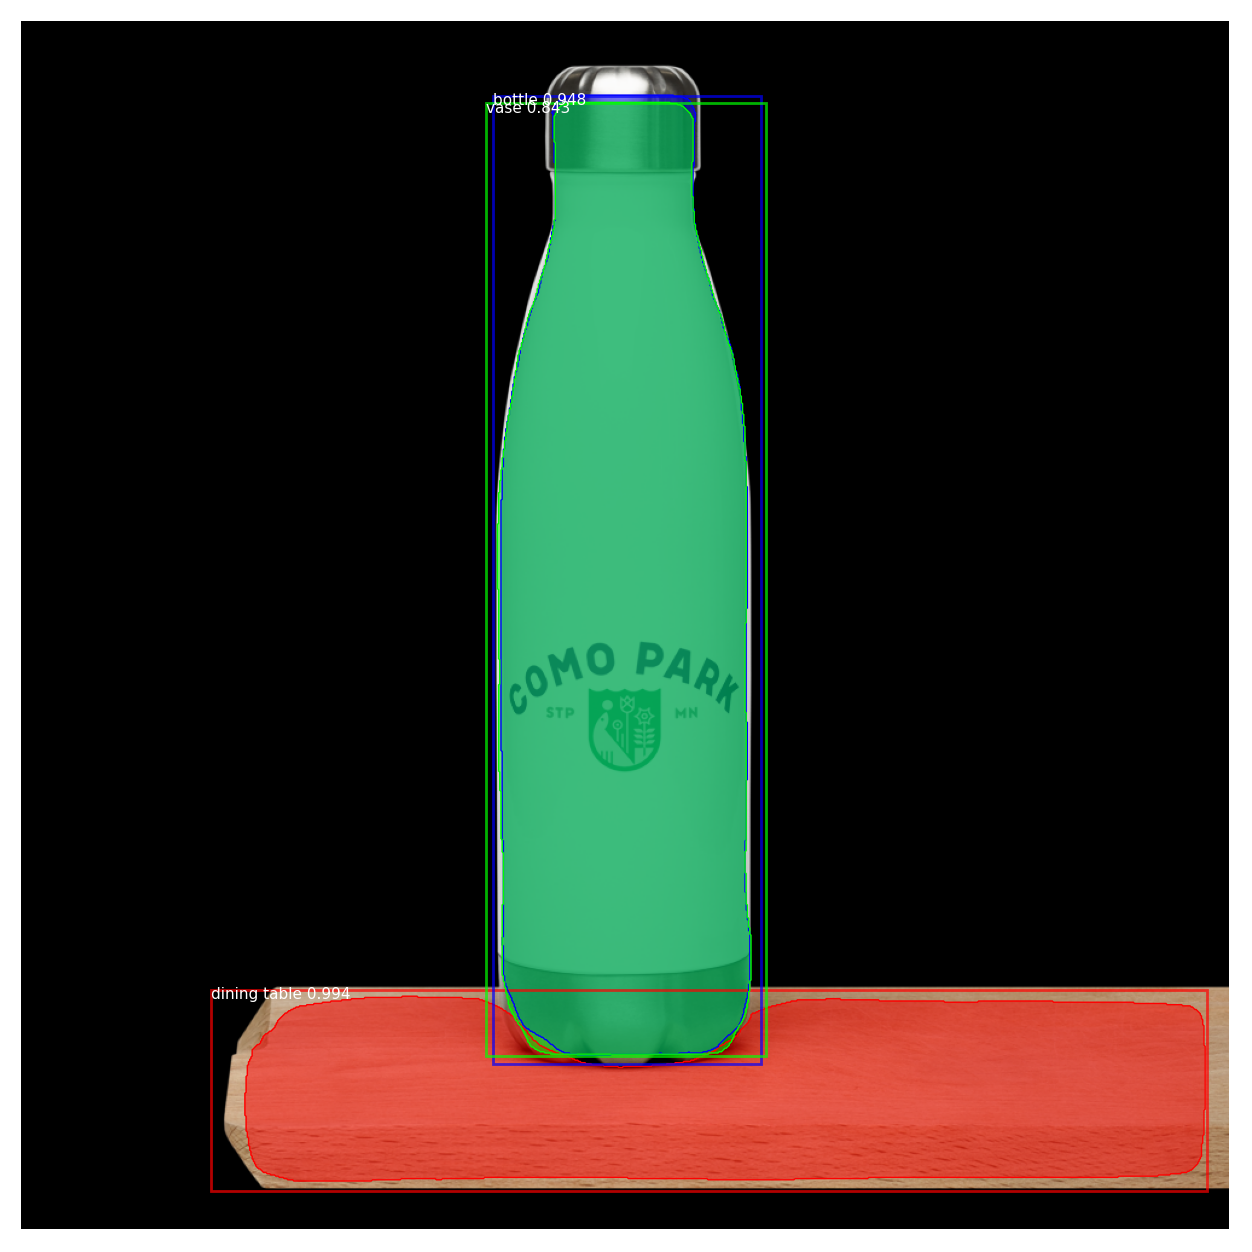

In [3]:

# LOADING A RANDOM IMAGE
# file_names = next(os.walk(IMG_DIR))[2]
# file_name = random.choice(file_names)
file_name = 'bottle.jpg'
image = skimage.io.imread(os.path.join(IMG_DIR, file_name))


# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=1)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                boxes=r['rois'], 
                                masks=r['masks'], 
                                class_ids=r['class_ids'], 
                                class_names=class_names, 
                                scores=r['scores'],
                                save_fig_path = os.path.join(RESULTS_DIR,file_name))

### TEST

Processing 1 images
image                    shape: (3000, 4000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 4000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
117


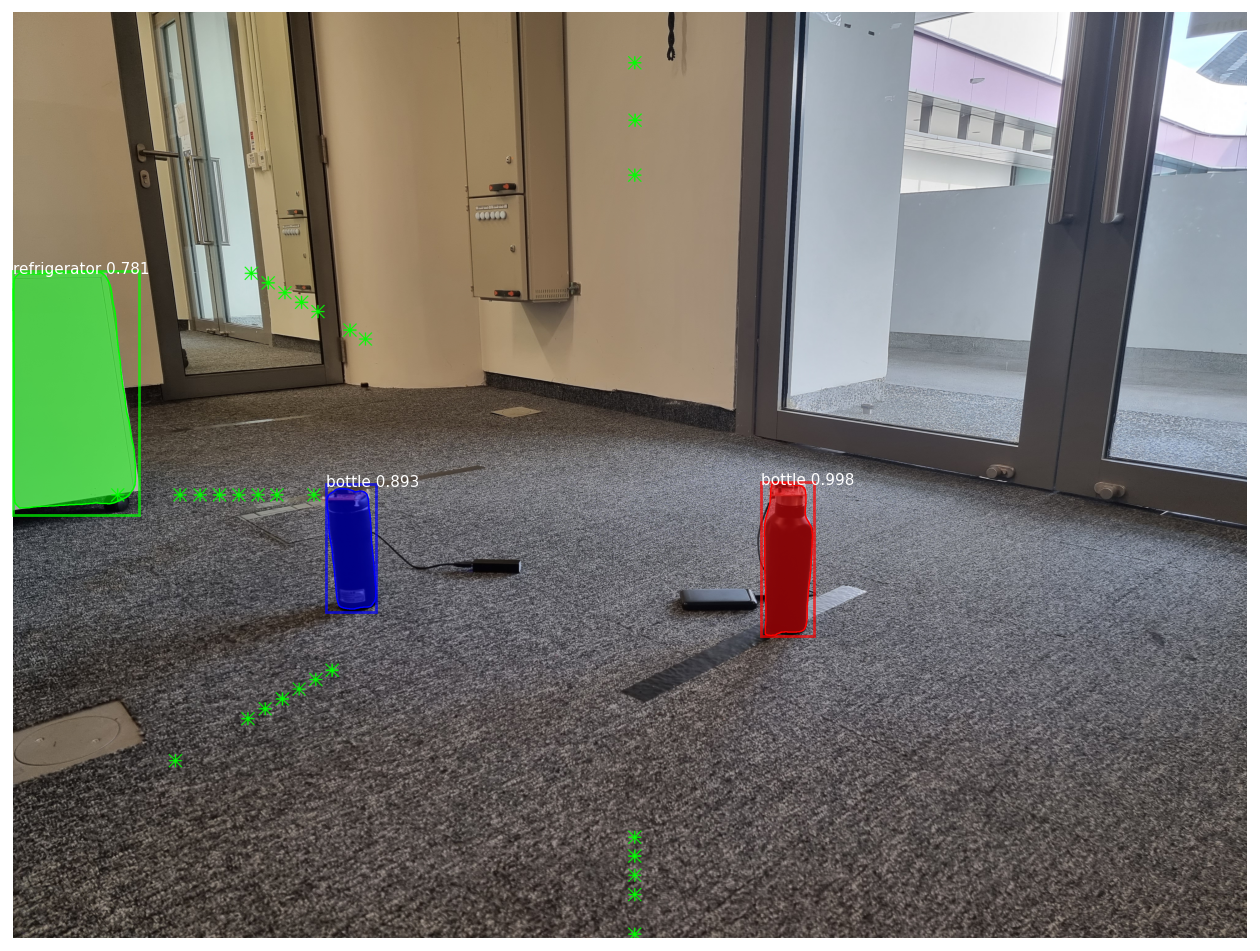

In [3]:
# # MANUAL 
file_name = 'before_turned.jpg'
image = cv2.imread(os.path.join(IMG_DIR, file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
results = model.detect([image], verbose=1)

xy = np.loadtxt('./aoa_data/aoa_data_after_calibration.csv', delimiter=',')
xy = xy.astype(int)
counter = 0
for item in xy:
    cv2.drawMarker(image, (item[0], item[1]), (0,255, 0), markerType=cv2.MARKER_STAR,
                    markerSize=40, thickness=2, line_type=cv2.LINE_AA)
    counter += 1
print(counter)
# Visualize results
r = results[0]
mrcnn.visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'],save_fig_path = os.path.join(RESULTS_DIR,file_name))


In [11]:
data_dir = "./images/"
for i in os.listdir(data_dir):
    print(os.path.join(data_dir,i))
    image = skimage.io.imread(os.path.join(data_dir,i))
    results = model.detect([image],verbose = 0)
    r = results[0]

    with open("./logs/"+i+".pkl","wb") as fw:
        pickle.dump(results,fw)

./images/bottle.jpg


./images/bottle.jpg
Processing 1 images
image                    shape: (1000, 1000, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


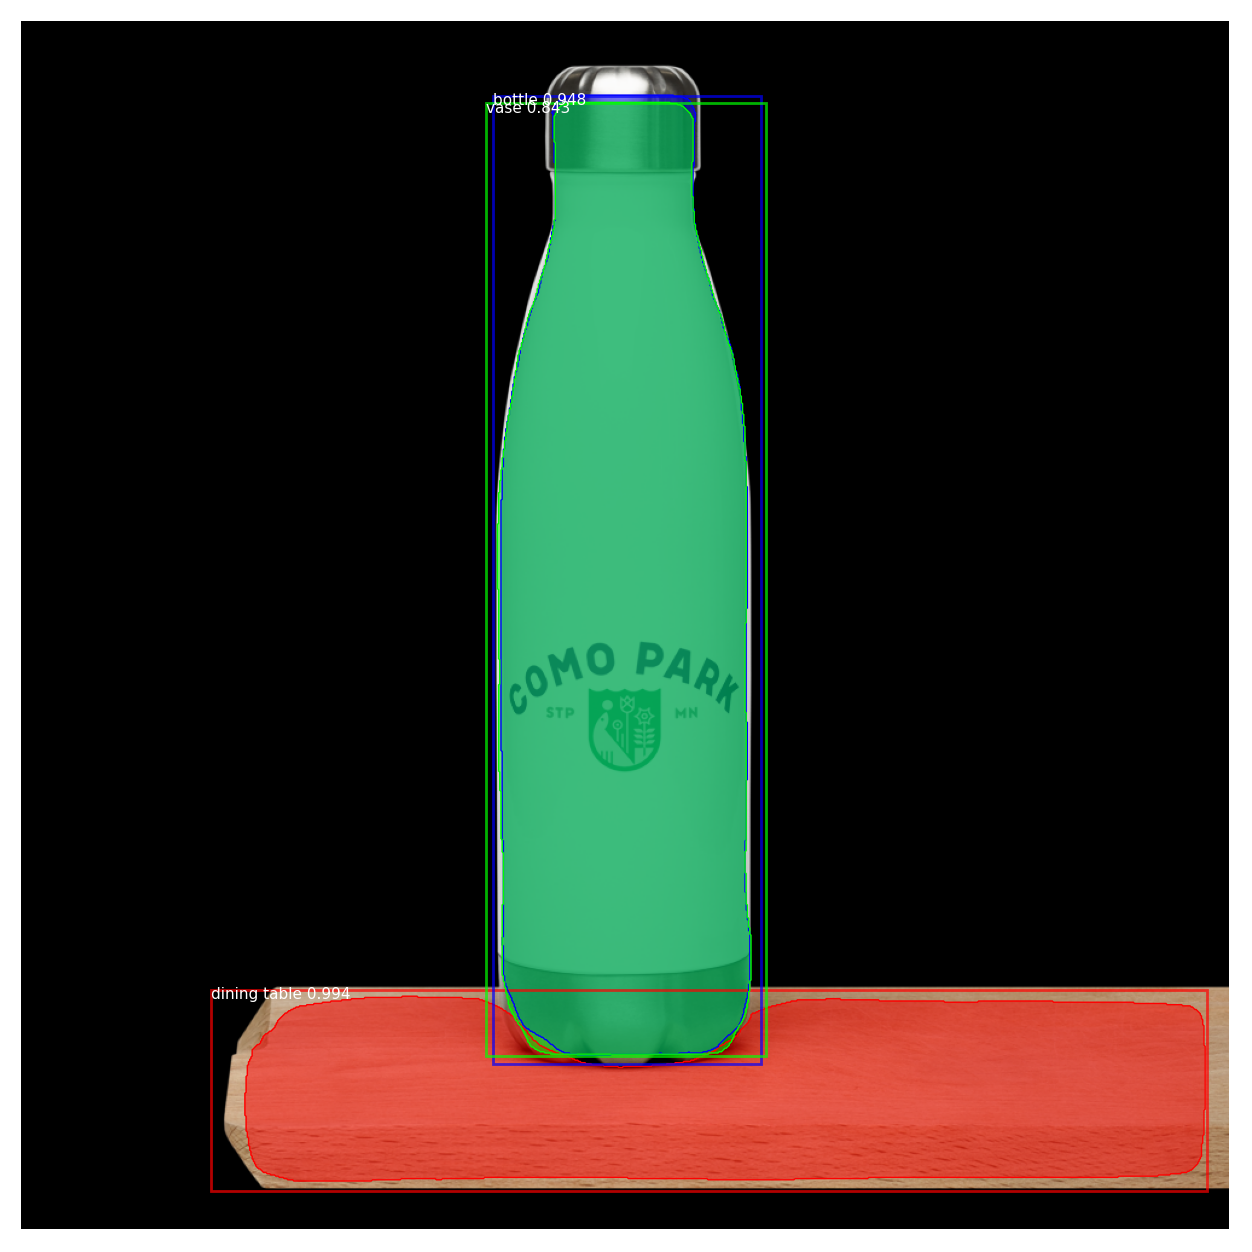

In [12]:
data_dir = "./images/"
for i in os.listdir(data_dir):
    print(os.path.join(data_dir,i))
    if(i.split('.')[-1]!='jpg'):
        break
    image = skimage.io.imread(os.path.join(data_dir,i))
    results = model.detect([image],verbose = 1)
    r = results[0]
    mrcnn.visualize.display_instances(image,r['rois'],r['masks'],r['class_ids'],class_names,r['scores'])
    masks = r['masks']
    for j in range(len(r['class_ids'])):
        if class_names[r['class_ids'][j]]=='bottle':
            answer = np.where(masks[:,:,j])
            answer = np.array(answer)
            file_name = './answer/'+i.split(".")[0]+"_"+str(r['scores'][j])+".csv"
            np.savetxt(file_name,answer.T,delimiter=",",fmt="%d")

In [25]:
def dye_mask(img1, results, positions, output = './results/img_seg.jpg'):
    masks = results[0]['masks']
    scores = results[0]["scores"]
    num_objects = len(scores)
    final_score = np.zeros(num_objects)
    for i in range(num_objects):
        mask = masks[:,:,i]
        count = 0
        size = np.where(mask)[0].shape[0]
        for x, y in positions:
            if mask[y, x]:
                count += 1
            final_score[i] = count / size * scores[i]
    k = np.argmax(final_score)
    mask = masks[:,:,k]
    mask = np.where(mask,255,0).astype('uint8')
    mask = np.expand_dims(mask,axis=2)
    img0 = np.zeros(mask.shape).astype('uint8')
    mask = np.concatenate((img0,mask, img0), axis=-1)
    img4 = cv2.addWeighted(img1,1,mask,1,0)
    cv2.imwrite(output,img4)



def draw_mask(img_dir, AoA_dir, all_dir, final_dir, data_dir):
    image = skimage.io.imread(img_dir)
    positions = np.loadtxt(AoA_dir, delimiter=',').astype(int)
    # image = cv2.cvtColor(cv2.imread(img_dir), cv2.COLOR_BGR2RGB)
    results = model.detect([image],verbose=1)
    r = results[0]
    mrcnn.visualize.display_instances(image, r['rois'], 
                                      r['masks'], 
                                      r['class_ids'], 
                                      class_names, 
                                      r['scores'], 
                                      output_file=all_dir)
    masks = r['masks']
    scores = r['scores']
    num_objects = len(scores)
    final_score = np.zeros(num_objects)
    now_masks = []

    for i in range(num_objects):
        mask = masks[:,:,i]
        count = 0
        size = np.where(mask)[0].shape[0]
        for x, y in positions:
            if(x>=4032) or(x<0):
                continue
            if(y>3024) or (y<0):
                continue
            if mask[y,x]:
                count += 1
        
        final_score[i] = count/size * scores[i]
        now_masks.append(mask)
    
    k = np.argmax(final_score)
    mask = masks[:, :, k]
    r["final_mask"] = mask
    mask = np.where(mask, 255, 0).astype("uint8")
    mask = np.expand_dims(mask, axis=2)
    img0 = np.zeros(mask.shape).astype("uint8")
    mask = np.concatenate((img0, mask, img0), axis=-1)
    img4 = cv2.addWeighted(img1, 1, mask, 1, 0)
    cv2.imwrite(final_dir, img4)
    r["masks"] = now_masks
    r["final_score"] = final_score
    import pickle
    fr = open(data_dir,"wb")
    pickle.dump(r,fr)
    

In [26]:
image = skimage.io.imread('./images/bottle.jpg')
image_ = cv2.imread('./images/bottle.jpg')
# positions = np.loadtxt('./answer/bottle_0.94845766.csv', delimiter=',').astype(int)
# dye_mask(image,results,positions)
print("Shapes: ",image.shape,"\t",image_.shape)

Shapes:  (1000, 1000, 3) 	 (1000, 1000, 3)
